#The Most Famous Musicians You've Never Heard of
By Sarah Helmbrecht and JT McDermott

https://skhelmbrecht.github.io/datasciencefinal



## **I. Introduction**


With the advent of music streaming services such as Spotify, Apple Music, and others, it has never been easier to discover new music and artists than it is today. Despite the overall trend towards globalization and unprecedented access to historic catalogs, music tastes are still largely stratified by demographics. This inspired our question: **who are the most famous artists and bands that we have never heard of?**

####**An Example: Cultural Disparities**
Do you recognize the person in this artist? If you aren't from India, probably not. This is King, one of the most popular artists in India, gaining more than 17 million streams this week alone. He's one of many examples of a popular artist that is relatively unknown outside of their primary target audience, in this case based on nationality and language.

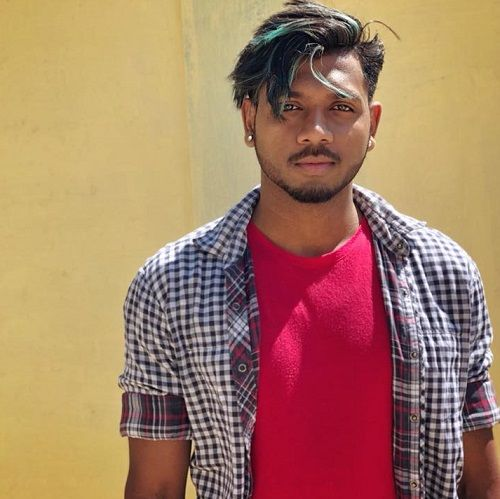

####**Context**
To understand our approach to answering this question, it helps to understand the perspective of us, the authors. We are both Gen-Z college students that were raised in the United States and primarily speak English.

The main factors that might hide an otherwise popular artist from us are language, geography, time, and our own personal preferences. Language and geography are simple to understand; people are generally unlikely to be exposed to media in a language they don't speak from a foreign country. This is increasingly changing with the advent of the international stars like Bad Bunny and others, but there are still many artists hidden from the rest of the world behind cultural barriers.



####**Motivation**
The initial motivation for this study was pure curiosity, stemming from a desire to better understand the world and the people who live in it. There are practical motivations as well, namely:

1. Identifying potential partners for advertisers
2. Understanding global trends in media and entertainment

Celebrity endorsements continue to be a major tool for advertisers, and can dramatically improve the ethos of a company when trying to penetrate a new market. Knowledge of famous musicians and particularly where and why they are famous is important for a successful partnership. For creators and producers of music, understanding trends and expanding horizons invites new influences, new ideas, and ultimately a better end product.

####**Our Model**
In our exploration, we decided use our data to relate international trends in musician popularity to understand domestic trends. Using streaming data from dozens of countries, our model captures which countries are the best predictors of an artist's fame among US Millenials. 

#II. Our Data
The rise of the internet and ubiquity of streaming services has created vast amounts of data about music habits. For our analysis, we focused on data that relates demographic factors to listening patterns. Our data comes from three main sources:


*   [Spotify](https://kworb.net/spotify/) (via Kworb) - data of top 200 streamed artistis in countries around the world
*   [YouGov](https://today.yougov.com/ratings/entertainment/popularity/all-time-music-artists/millennials) - polling of Millenials regarding their familiarity with 200 popular artists
* [Acclaimed Music](http://www.acclaimedmusic.net/) - Collection of top 1000 artists of all time and decade-by-decade data of their releases

The importation of this data was done primarily with webscraping. We explain in more detail the unique challenges each data set presented below.







#**III. ETL & EDA**

In [ ]:
#Mount Google Drive and move into correct directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/cmps3160

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cmps3160


####**Tools for Analysis**

This section will keep track of the tools we will use for our analysis, namely imported Python libraries. 

In [ ]:
#This cell imports libraries for analysis

import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import requests
import re

###**YouGov Music Artists Poll**

The following section will use a national poll to identify what percentage of American millenials have heard of certain musical artists.

The dataset, sourced from [YouGov](https://today.yougov.com/ratings/entertainment/fame/contemporary-music-artists/millennials), ranks artists by the percentage of people polled (born from 1949 to 1999) who have heard of them, as of 2022. This website is particularly difficult to scrape because it has a "Load More" button and does not store the data in tabular format. We typed the data into an Excel spreadsheet instead of scraping it.

In [ ]:
!pwd

/content/drive/MyDrive/cmps3160


In [ ]:
#Read and display YouGov data from Excel spreadsheet
df_yougov = pd.read_excel("/content/drive/MyDrive/cmps3160/yougovdata.xlsx")
df_yougov

,Name,Fame,Popularity
0,Adele,98,70
1,Selena Gomez,98,62
2,Katy Perry,97,59
3,Rihanna,96,61
4,Billie Eilish,96,58
...,...,...,...
245,Chris Stapleton,59,37
246,Tiesto,59,36
247,The 1975,59,36
248,Greta Van Fleet,59,31


###**International Music**

The following analysis considers data from Spotify of daily streaming trends, sourced from kworb.net, which has the global daily rank of songs as well as the country-by-country breakdown.The data can be viewed [here](https://kworb.net/spotify/).


####Importing our data
Let's first take a look at our international Spotify data from Kworb. Accessing and using this data is a bit tricky because each different country has a different table with its own national data on its own page. The following cell uses a for-loop along with some string comprehension in order to read each table from their respective URL. Each URL is identical except a two-letter country identifier, so using a regular expression and slicing we can iterate over each, reformatting it to be tidy, and adding each table to one large table we can use for analysis.

In [ ]:
#Scrape Spotify Weekly Streams Data from each country

#Use requests and BeautifulSoup to access the main Spotify page
#which has a table with links to each country table
r = requests.get("https://kworb.net/spotify/")

soup = BeautifulSoup(r.content)
soup.prettify()

#Use soup.findall() with a RegEx to grab every weekly URL and store as a list of
#HTML
kworb_spotify = soup.findAll('a', attrs={'href': re.compile("country/.._weekly.html")})

#This dataframe will store all of our data
df_spotify = pd.DataFrame()

#This for loop iterates over each link in kworb_spotify, importing each, reformatting
#and finally joining with our df_spotify
for link in kworb_spotify:

  #Read in each URL to a dataframe
  tempstr = str(link)
  #Select the part of the string that contains the variable part of the URL
  tempstr = tempstr[9:31]
  #Grab the two-character country code for each table
  country_mark = tempstr[8:10]
  #Create a string of the URL to pass to pandas to read
  tempURL = "https://kworb.net/spotify/" + tempstr
  #Read the URL and then add table to a temporary dataframe
  tempdf = pd.read_html(tempURL) 
  df_temp = tempdf[0]
  #Adjust dataframes as they come in

  #Split the "Artist and Title" column into two separate columns
  new_cols = df_temp["Artist and Title"].str.split(" - ", expand=True)
  df_temp["Artist"], df_temp["Title"] = new_cols[0], new_cols[1]

#Create df with relevant columns in proper order
  df_temp = df_temp[["Pos", 
                         "P+", 
                         "Artist", 
                         "Title",
                         "Streams"
                         ]]
  df_temp["Country"] = country_mark
  df_spotify = pd.concat([df_spotify, df_temp], axis=0, ignore_index=True)
  
#Display our resulting dataframe
df_spotify




<ipython-input-54-f20365b2652f>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Country"] = country_mark


,Pos,P+,Artist,Title,Streams,Country
0,1,NEW,Metro Boomin,Creepin',13367331,us
1,2,NEW,Metro Boomin,Superhero (Heroes & Villains) [with Future & C...,11500298,us
2,3,-1,Brenda Lee,Rockin' Around The Christmas Tree,11338691,us
3,4,-3,Drake,Rich Flex,10352357,us
4,5,-1,Mariah Carey,All I Want for Christmas Is You,9246348,us
...,...,...,...,...,...,...
14053,196,-17,HIEUTHUHAI,Bật Nhạc Lên,58422,vn
14054,197,-42,Mai Tiến Dũng,Người Như Anh,58223,vn
14055,198,-1,Suni Hạ Linh,Em Đã Biết,58120,vn
14056,199,-15,benny blanco,Bad Decisions,57763,vn


The dataframe above features 14,058 rows, with each row representing a particular song's performance in a given country. The "Pos" and "P+" columns show the track's position and position change in its respective country's chart.
Let's familiarize ourself with this data by looking at some summary statistics about streams:

In [ ]:
#use .describe to get summary statistics
df_spotify['Streams'].describe()

count    1.405800e+04
mean     3.313521e+05
std      6.984888e+05
min      1.008000e+03
25%      3.394925e+04
50%      8.355000e+04
75%      3.347408e+05
max      1.336733e+07
Name: Streams, dtype: float64

At first glance, we see a wide range of orders of magnitude, ranging from hundreds to millions of streams. This is a result of the inclusion of countries as small as Andorra (pop. 77,000) and Malta (pop. 550,000). Looking at the graph below, we can see just how top-heavy it really is:

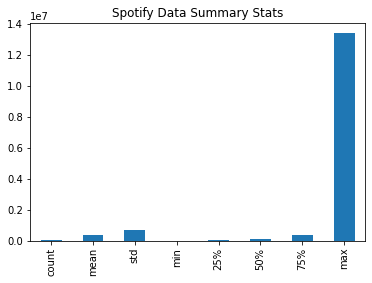

In [ ]:
df_spotify['Streams'].describe().plot.bar(title='Spotify Data Summary Stats')

This tells us that in general, listens are concentrated in smash hit songs in large markets, which aligns with common intuition about how fame works. However,this data still includes data from the USA and other English-speaking countries, so it doesn't tell us much about artists and listening patterns outside the Anglosphere. Let's change this by dropping English-speaking countries and looking at the results.

In [ ]:
#This cell filters out 
df_spotify_nonAnglo = df_spotify[df_spotify["Country"] != 'us'] #USA
df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'gb'] #United Kingdom
df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'ca'] #Canada
df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'au'] #Australia
df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'nz'] #New Zealand
df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'ie'] #Ireland

#Sort the datafram by streams in descending order and display the first 10 rows
df_spotify_nonAnglo.sort_values("Streams", ascending=False).head(n=10)

<ipython-input-57-cc362f745abe>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'gb'] #United Kingdom
<ipython-input-57-cc362f745abe>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'ca'] #Canada
<ipython-input-57-cc362f745abe>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'au'] #Australia
<ipython-input-57-cc362f745abe>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'nz'] #New Zealand
<ipython-input-57-cc362f745abe>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify["Country"] != 'ie'] #Ireland


,Pos,P+,Artist,Title,Streams,Country
6058,1,=,King,Maan Meri Jaan,12487947,in
1458,1,=,MC MENOR HR,Evoque Prata,8874752,br
13058,1,+1,Mert Demir,Antidepresan,8163927,tr
1459,2,+1,Israel & Rodolffo,Bombonzinho,7330459,br
1460,3,-1,Gustavo Mioto,Eu Gosto Assim,7084349,br
8258,1,=,Manuel Turizo,La Bachata,6995865,mx
8259,2,+1,Bellakath,Gatita,6380641,mx
6059,2,=,Pritam,Kesariya,6360181,in
8260,3,+1,Bad Bunny,Me Porto Bonito,6302217,mx
8261,4,-2,Grupo Frontera,No Se Va,6147330,mx


By sorting the non-Anglosphere table in descending order like above, we can see the top performing tracks of the week that we, the creators, likely haven't heard. Here we see King again at the top of the list. In general, we see that the most streamed songs are streamed in large countries like India, Brazil, and Mexico. We can also compare the distribution of streams to the original below:

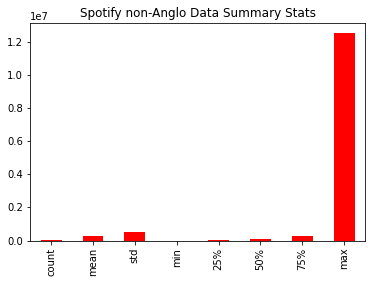

In [ ]:
#Plot non-Anglo summary stats
df_spotify_nonAnglo['Streams'].describe().plot.bar(title='Spotify non-Anglo Data Summary Stats', color="red")

The global market minus English-speaking countries is still quite top heavy. Streams by song by country provide some interesting insight, but more important to our question is Artists. Let's take a count of each time an artist appears in our frame:

In [ ]:
#Get the value counts of each different artist name in our dataframe:
df_spotify_nonAnglo["Artist"].value_counts()

Bad Bunny           543
Metro Boomin        394
The Weeknd          247
RM                  145
Feid                140
                   ... 
Hamo ElTikha          1
Ramy Sabry            1
Disco Misr            1
Manuel Rodriguez      1
Mai Tiến Dũng         1
Name: Artist, Length: 2854, dtype: int64

These values are important because while they don't necessarily reflect which artists are most popular in total, they show which artists are popular in many different countries, and ultimatlely have the most international appeal. Let's plot the top 10 artists on this list on a bar graph to visualize:

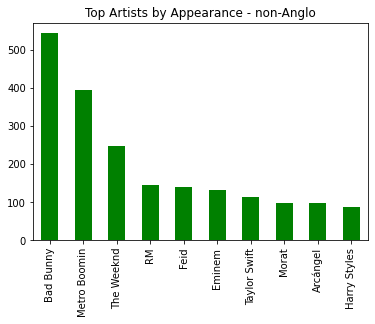

In [ ]:
#Restrict our series to the top 10 artists
top10_artist_series = df_spotify_nonAnglo["Artist"].value_counts()[:10]

#Plot a horizontal bar graph
top10_artist_series.plot.bar(title="Top Artists by Appearance - non-Anglo", color="green")

We see some familiar names like The Weeknd and Taylor Swift, along with some unknowns like RM, Feid, and Morat. Overall, this is fairly insightful as we can see known and unknown artists alike and their international appeal. Next, let's consider aggregate stream numbers by grouping songs together by artist in a pivot table.

In [ ]:
nonAnglo_cube = df_spotify_nonAnglo.pivot_table(index="Artist",
                                                columns=["Country"],
                                                values="Streams",
                                                aggfunc=np.sum,
                                                fill_value=0,


)

nonAnglo_cube

Country,ad,ae,ar,at,be,bg,bo,br,ch,cl,...,sg,sk,sv,th,tr,tw,ua,uy,vn,za
Artist,,,,,,,,,,,,,,,,,,,,,
$uicideboy$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(G)I-DLE,0,0,0,0,0,0,0,0,0,0,...,159201,0,0,109303,0,280676,0,0,60074,0
01099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
070 Shake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.Cuz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
陳華,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,106325,0,0,0,0
音田 雅則,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
颜人中,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,160255,0,0,0,0


That's a lot of zeros! And a lot of rows, so we should narrow down our search for our visualization. All those zeros mean the artist doesn't show up in a given country's Spotify Weekly Top 200, helping to illustrate the stratification of international tastes. We'll consider artists with more than 5 million streams below and graph by country of streams.

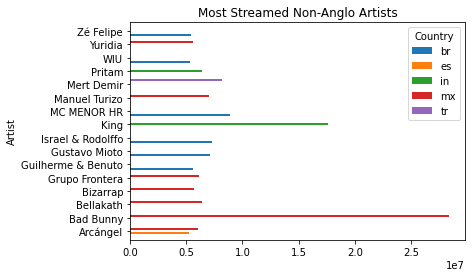

In [ ]:
#Drop rows with less than 5 million streams, then recreate pivot table
df_spotify_nonAnglo = df_spotify_nonAnglo[df_spotify_nonAnglo['Streams'] >= 5000000]
nonAnglo_cube = df_spotify_nonAnglo.pivot_table(index="Artist",
                                                columns=["Country"],
                                                values="Streams",
                                                aggfunc=np.sum,
                                                fill_value=0,
)
#Make a horizontal plot of top streamed artist and streams by country
nonAnglo_cube.plot.barh(width=0.8, title="Most Streamed Non-Anglo Artists")

This chart show not only top artists, but also *where* most of their streams come from. An advertiser looking for a potential spokesperson could look at this to determine if a given musician is appropriate for their target audience.

Next, we will pair this data with polling data from YouGov to begin building our model.

###**Linking Spotify International Weekly Top Charts with YouGov Polling Data**

First, we need to re-import the Spotify Weekly data to get it into a format that can be easily merged with the YouGov data.

In [ ]:
import re

r = requests.get("https://kworb.net/spotify/")

soup = BeautifulSoup(r.content)
soup.prettify()

kworb_spotify = soup.findAll('a', attrs={'href': re.compile("country/.._weekly.html")})

df_spotify = pd.DataFrame()
countries = []
for link in kworb_spotify:

  #Read in each URL to a dataframe
  tempstr = str(link)
  #print(tempstr[9:31])
  tempstr = tempstr[9:31]
  #Grab the two-character country code for each table
  country_mark = tempstr[8:10]
  #print(country_mark)
  tempURL = "https://kworb.net/spotify/" + tempstr
  #print(tempURL)
  tempdf = pd.read_html(tempURL) 
  df_temp = tempdf[0]
  #Adjust dataframes as they come in

  #Split the "Artist and Title" column into two separate columns
  new_cols = df_temp["Artist and Title"].str.split(" - ", expand=True)
  df_temp["Artist"], df_temp["Title"] = new_cols[0], new_cols[1]

  # Append country codes to list
  countries.append(country_mark)
  # Narrow down dataframe to country streams, artist, and title
  df_temp[country_mark + " Streams"] = df_temp["Streams"]
  df_temp = df_temp[["Artist", "Title", country_mark + " Streams"]]
  # Concatenate dataframes
  df_spotify = pd.concat([df_spotify, df_temp], axis=0, ignore_index=True)

df_spotify

,Artist,Title,us Streams,gb Streams,ad Streams,ar Streams,au Streams,at Streams,be Streams,bo Streams,...,es Streams,se Streams,ch Streams,tw Streams,th Streams,tr Streams,ua Streams,ae Streams,uy Streams,vn Streams
0,Metro Boomin,Creepin',13367331.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Metro Boomin,Superhero (Heroes & Villains) [with Future & C...,11500298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brenda Lee,Rockin' Around The Christmas Tree,11338691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Drake,Rich Flex,10352357.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mariah Carey,All I Want for Christmas Is You,9246348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14053,HIEUTHUHAI,Bật Nhạc Lên,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58422.0
14054,Mai Tiến Dũng,Người Như Anh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58223.0
14055,Suni Hạ Linh,Em Đã Biết,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58120.0
14056,benny blanco,Bad Decisions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57763.0


Next, we clean the data by filling N/A values with 0 and combining rows with the same artist by adding streams by country.

In [ ]:
df_spotify = df_spotify.fillna(0)
df_spotify = df_spotify.drop(["Title"], axis=1)
for c in countries:
  df_spotify[c] = df_spotify.groupby(["Artist"])[c + " Streams"].transform("sum")
for c in countries:
  df_spotify = df_spotify.drop([c + " Streams"], axis=1)
df_spotify = df_spotify.drop_duplicates()
df_spotify = df_spotify.reset_index()
df_spotify = df_spotify.drop(["index"], axis=1)
df_spotify

,Artist,us,gb,ad,ar,au,at,be,bo,br,...,es,se,ch,tw,th,tr,ua,ae,uy,vn
0,Metro Boomin,103210991.0,11552927.0,0.0,0.0,5591652.0,799536.0,993846.0,0.0,0.0,...,0.0,986741.0,1558196.0,0.0,0.0,1191451.0,99847.0,528173.0,0.0,85851.0
1,Brenda Lee,11338691.0,3601199.0,0.0,0.0,1002049.0,343441.0,179753.0,0.0,0.0,...,359191.0,704293.0,275190.0,0.0,0.0,0.0,0.0,31589.0,0.0,57359.0
2,Drake,39754913.0,2195614.0,0.0,0.0,2321183.0,137172.0,126636.0,0.0,0.0,...,0.0,226335.0,174699.0,0.0,0.0,0.0,28793.0,126733.0,0.0,0.0
3,Mariah Carey,12127792.0,5104622.0,0.0,0.0,1285537.0,480178.0,406480.0,0.0,0.0,...,880081.0,1163102.0,429045.0,79088.0,105312.0,0.0,25911.0,42601.0,0.0,113698.0
4,Bobby Helms,8432197.0,2837096.0,0.0,0.0,805163.0,271058.0,155574.0,0.0,0.0,...,377714.0,648371.0,244200.0,0.0,0.0,0.0,0.0,27601.0,0.0,59257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,Orange,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59426.0
2932,SOOBIN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59312.0
2933,Uyên Linh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58978.0
2934,Ha Anh Tuan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58842.0


###**YouGov vs. Spotify Global Weekly Charts**

First, we will merge the Spotify weekly data with the YouGov poll data. The data is aligned to provide the number of streams within each country, broken down by artist.

In [ ]:
df_spotify["Name"] = df_spotify["Artist"]
df_spotify_yougov = df_yougov.merge(df_spotify, on=["Name", "Name"], how="outer")
df_spotify_yougov = df_spotify_yougov.fillna(0)
df_spotify_yougov = df_spotify_yougov.drop(["Artist"], axis=1)
df_spotify_yougov

,Name,Fame,Popularity,us,gb,ad,ar,au,at,be,...,es,se,ch,tw,th,tr,ua,ae,uy,vn
0,Adele,98.0,70.0,0.0,549377.0,0.0,0.0,349096.0,0.0,158690.0,...,0.0,159594.0,61990.0,72281.0,0.0,0.0,0.0,18561.0,0.0,0.0
1,Selena Gomez,98.0,62.0,0.0,0.0,2484.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Katy Perry,97.0,59.0,0.0,0.0,0.0,0.0,0.0,69294.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Rihanna,96.0,61.0,0.0,642194.0,0.0,0.0,411205.0,0.0,230398.0,...,0.0,233342.0,126824.0,76827.0,0.0,0.0,0.0,20575.0,0.0,0.0
4,Billie Eilish,96.0,58.0,2284356.0,509188.0,0.0,0.0,606425.0,0.0,101632.0,...,0.0,151783.0,67601.0,0.0,0.0,0.0,0.0,33851.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3086,Orange,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59426.0
3087,SOOBIN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59312.0
3088,Uyên Linh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58978.0
3089,Ha Anh Tuan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58842.0


We predict that the best predictor of fame among U.S. millenials will be streams in the United States.

The following scatterplot visualizes this relationship. 

In [ ]:
df_spotify_yougov["us"].corr(df_spotify_yougov["Fame"])

0.10797305485754818

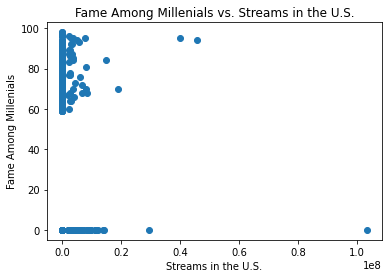

In [ ]:
plt.scatter(df_spotify_yougov["us"], df_spotify_yougov["Fame"])
plt.title("Fame Among Millenials vs. Streams in the U.S.")
plt.xlabel("Streams in the U.S.")
plt.ylabel("Fame Among Millenials")
plt.show()

It's clear from the low correlation and non-linear relationship in the scatterplot that an artist's streams in the US this week are not a strong predictor of whether American millenials have heard of them.

Now, we'll create a dataset of all the artists who are ranked #1 in any country in the world this week on the Spotify charts.

In [ ]:
df_unknown_artists = pd.DataFrame()
for c in countries:
  max = df_spotify_yougov[c].idxmax()
  df_unknown_artists = df_unknown_artists.append(df_spotify_yougov.iloc[max], ignore_index=True)
df_unknown_artists = df_unknown_artists.drop_duplicates()
df_unknown_artists = df_unknown_artists.reset_index()
df_unknown_artists

,index,Name,Fame,Popularity,us,gb,ad,ar,au,at,...,es,se,ch,tw,th,tr,ua,ae,uy,vn
0,0,Metro Boomin,0.0,0.0,103210991.0,11552927.0,0.0,0.0,5591652.0,799536.0,...,0.0,986741.0,1558196.0,0.0,0.0,1191451.0,99847.0,528173.0,0.0,85851.0
1,2,C. Tangana,0.0,0.0,0.0,0.0,7843.0,0.0,0.0,0.0,...,1812611.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,YSY A,0.0,0.0,0.0,0.0,0.0,12331458.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,532530.0,0.0
3,7,Bad Bunny,70.0,34.0,18846024.0,0.0,6256.0,9244177.0,0.0,0.0,...,11275926.0,0.0,133324.0,0.0,0.0,0.0,0.0,13553.0,569191.0,0.0
4,8,Guilherme & Benuto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12,Feid,0.0,0.0,0.0,0.0,0.0,1343304.0,0.0,0.0,...,7290402.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254780.0,0.0
6,15,Calin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22,Gettomasa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,23,SDM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,25,SIDARTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


All but 3 of the top national artists do not make the list of artists whom millenials have heard of. This list allows us to identify which very famous artists are not known to American millenials.

###**Top 1000 Artists of All Time**
This dataset ranks the top 1000 artists of all time. It combines data across thousands of critics' reviews and lists to rank the artists. It is useful for identifying the all-time most well-regarded and successful artists.

The 1000 entries are divided between 5 pages, so we'll read in each page into a separate dataframe, then concatenate them.

In [ ]:
import requests

URL_FIRST200 = "http://www.acclaimedmusic.net/061024/1948-09art.htm"
page = requests.get(URL_FIRST200)
soup = BeautifulSoup(page.content, "html.parser")
df_first200 = pd.read_html(str(soup.find("table")))
df_first200 = df_first200[0]

URL_SECOND200 = "http://www.acclaimedmusic.net/061024/1948-09art2.htm"
page = requests.get(URL_SECOND200)
soup = BeautifulSoup(page.content, "html.parser")
df_second200 = pd.read_html(str(soup.find("table")))
df_second200 = df_second200[0]

URL_THIRD200 = "http://www.acclaimedmusic.net/061024/1948-09art3.htm"
page = requests.get(URL_THIRD200)
soup = BeautifulSoup(page.content, "html.parser")
df_third200 = pd.read_html(str(soup.find("table")))
df_third200 = df_third200[0]

URL_FOURTH200 = "http://www.acclaimedmusic.net/061024/1948-09art4.htm"
page = requests.get(URL_FOURTH200)
soup = BeautifulSoup(page.content, "html.parser")
df_fourth200 = pd.read_html(str(soup.find("table")))
df_fourth200 = df_fourth200[0]

URL_FIFTH200 = "http://www.acclaimedmusic.net/061024/1948-09art5.htm"
page = requests.get(URL_FIFTH200)
soup = BeautifulSoup(page.content, "html.parser")
df_fifth200 = pd.read_html(str(soup.find("table")))
df_fifth200 = df_fifth200[0]

df_alltime = pd.concat([df_first200, df_second200, df_third200, df_fourth200,
                        df_fifth200], axis=0)

df_alltime

,0,1,2,3,4,5,6,7,8,9,10
0,NaN,NaN,Albums,Songs,1900-49,50s,60s,70s,80s,90s,00s
1,1.0,The Beatles,1,1,NaN,NaN,1,94,NaN,NaN,NaN
2,2.0,The Rolling Stones,3,2,NaN,NaN,2,2,98,NaN,NaN
3,3.0,Bob Dylan,2,6,NaN,NaN,3,16,177,41,23
4,4.0,David Bowie,4,9,NaN,NaN,113,1,47,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
205,996.0,The Sundays,764,1369,NaN,NaN,NaN,NaN,513,238,NaN
206,997.0,Herbert,738,NaN,NaN,NaN,NaN,NaN,NaN,439,184
207,998.0,Stephen Stills,739,NaN,NaN,NaN,NaN,249,NaN,NaN,NaN
208,999.0,Mazzy Star,970,895,NaN,NaN,NaN,NaN,NaN,231,NaN


####Adjusting Our Dataframe
The dataframe from the previous cell doesn't have descriptive column names, so we'll replace them with the original names that were read in as rows. There are also NaN values for each time period where an artist didn't have any hits, so we'll replace them with 0s. Throughout the dataset, we also have the column names stored as rows. We will drop all of these rows from the dataset.

In [ ]:
# Rename columns
df_alltime.columns = ["Ranking", "Artist", "Albums", "Songs", "1900-49", "50s",
                      "60s", "70s", "80s", "90s", "00s"]
# Replace NA values with 0
df_alltime = df_alltime.fillna(0)
# Drop any other rows containing column titles
df_alltime = df_alltime[df_alltime["1900-49"] != "1900-49"]
# Reset indices and drop "index" column
df_alltime = df_alltime.reset_index()
df_alltime = df_alltime.drop(labels=["index"], axis=1)
df_alltime

,Ranking,Artist,Albums,Songs,1900-49,50s,60s,70s,80s,90s,00s
0,1.0,The Beatles,1,1,0,0,1,94,0,0,0
1,2.0,The Rolling Stones,3,2,0,0,2,2,98,0,0
2,3.0,Bob Dylan,2,6,0,0,3,16,177,41,23
3,4.0,David Bowie,4,9,0,0,113,1,47,0,0
4,5.0,Led Zeppelin,5,8,0,0,16,6,0,0,252
...,...,...,...,...,...,...,...,...,...,...,...
995,996.0,The Sundays,764,1369,0,0,0,0,513,238,0
996,997.0,Herbert,738,0,0,0,0,0,0,439,184
997,998.0,Stephen Stills,739,0,0,0,0,249,0,0,0
998,999.0,Mazzy Star,970,895,0,0,0,0,0,231,0


In [ ]:
df_alltime.dtypes

Ranking    float64
Artist      object
Albums      object
Songs       object
1900-49     object
50s         object
60s         object
70s         object
80s         object
90s         object
00s         object
dtype: object

Since the counts of albums, hit songs, and songs by decade are recognized as objects, we will convert them to integers.

In [ ]:
df_alltime["Albums"] = pd.to_numeric(df_alltime["Albums"])
df_alltime["Songs"] = pd.to_numeric(df_alltime["Songs"])
df_alltime["1900-49"] = pd.to_numeric(df_alltime["1900-49"])
df_alltime["50s"] = pd.to_numeric(df_alltime["50s"])
df_alltime["60s"] = pd.to_numeric(df_alltime["60s"])
df_alltime["70s"] = pd.to_numeric(df_alltime["70s"])
df_alltime["80s"] = pd.to_numeric(df_alltime["80s"])
df_alltime["90s"] = pd.to_numeric(df_alltime["90s"])
df_alltime["00s"] = pd.to_numeric(df_alltime["00s"])
df_alltime.dtypes

Ranking    float64
Artist      object
Albums       int64
Songs        int64
1900-49      int64
50s          int64
60s          int64
70s          int64
80s          int64
90s          int64
00s          int64
dtype: object

####Analyzing Top 1000 Data
Now, let's look at the distribution of song releases for the artists in the top 1000.

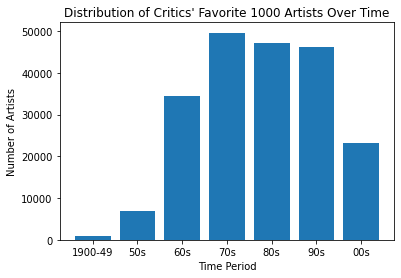

In [ ]:
features = ["1900-49", "50s", "60s", "70s", "80s", "90s", "00s"]
plt.bar(features, df_alltime[features].sum(axis=0))
plt.title("Distribution of Critics' Favorite 1000 Artists Over Time")
plt.xlabel("Time Period")
plt.ylabel("Number of Artists")
plt.show()

In [ ]:
print("Mean Rankings")
print("1900-49: " + str(df_alltime[df_alltime["1900-49"] > 0]["Ranking"].mean()))
print("50s: " + str(df_alltime[df_alltime["50s"] > 0]["Ranking"].mean()))
print("60s: " + str(df_alltime[df_alltime["60s"] > 0]["Ranking"].mean()))
print("70s: " + str(df_alltime[df_alltime["70s"] > 0]["Ranking"].mean()))
print("80s: " + str(df_alltime[df_alltime["80s"] > 0]["Ranking"].mean()))
print("90s: " + str(df_alltime[df_alltime["90s"] > 0]["Ranking"].mean()))
print("00s: " + str(df_alltime[df_alltime["00s"] > 0]["Ranking"].mean()))

Mean Rankings
1900-49: 575.9444444444445
50s: 488.0990990990991
60s: 434.8884462151394
70s: 378.9563758389262
80s: 436.26027397260276
90s: 451.1048951048951
00s: 458.73762376237624


The bar graph shows that the artists on the top 1000 list primarily made music in the 70s, then the 80s, then the 90s. The means of the rankings for each time period demonstrate that on average, critics ranked artists who made music from 1900-49 the highest, followed by the 50s, then the 00s.

###**YouGov vs. Critics' Top 1000**

We will visualize the correlation between critics' ratings and which artists millenials have heard of.

In [ ]:
df_alltime["Name"] = df_alltime["Artist"]
df_yougov_top1000 = df_yougov.merge(df_alltime, on=["Name", "Name"], how="inner")
df_yougov_top1000 = df_yougov_top1000.fillna(0)
df_yougov_top1000 = df_yougov_top1000.drop(["Artist"], axis=1)
df_yougov_top1000

,Name,Fame,Popularity,Ranking,Albums,Songs,1900-49,50s,60s,70s,80s,90s,00s
0,Justin Timberlake,96,56,644.0,1316,301,0,0,0,0,0,0,90
1,Alicia Keys,96,64,620.0,699,555,0,0,0,0,0,0,82
2,Kanye West,95,47,125.0,139,133,0,0,0,0,0,0,7
3,Beyonce,94,55,477.0,0,187,0,0,0,0,0,0,58
4,Kelly Clarkson,94,58,709.0,0,326,0,0,0,0,0,0,107
5,Coldplay,91,53,138.0,145,173,0,0,0,0,0,0,9
6,Pharrell Williams,90,62,955.0,0,502,0,0,0,0,0,0,152
7,Gwen Stefani,89,60,774.0,0,371,0,0,0,0,0,0,117
8,The Eagles,86,56,91.0,137,73,0,0,0,27,0,0,0
9,Gorillaz,79,53,216.0,291,151,0,0,0,0,0,0,13


We can see that only 18 of the top 419 artists whom millenials had heard of even made the critics' top 1000.

Now, for these artists who appeared in both datasets, let's analyze the correlation between position in the critics' list and the percentage of millenials who had heard of an artist.

In [ ]:
df_yougov_top1000["Ranking"].corr(df_yougov_top1000["Fame"])

-0.15508634448155484

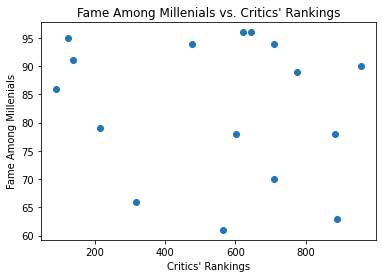

In [ ]:
plt.scatter(df_yougov_top1000["Ranking"], df_yougov_top1000["Fame"])
plt.title("Fame Among Millenials vs. Critics' Rankings")
plt.xlabel("Critics' Rankings")
plt.ylabel("Fame Among Millenials")
plt.show()

As we can see from the scatterplot and low correlation, there is no relationship between critics' rankings and which artists millenials have heard of. It seems that critics' rankings are not a predictor of fame among American millenials.

#**IV. Model**

In the process of analyzing multiple datasets, we have yet to find a strong predictor of whether American millenials have heard of musical artists. Therefore, we are looking back to our Spotify Global Weekly data to see if certain countries' streams are a better predictor than others.

We want to know which countries' streams have the greatest and least predictive power for whether millenials have heard of an artist. We decided to fit a Random Forest Regressor to data from the Spotify Global Weekly and YouGov datasets. Random Forest for regression is similar to k-Nearest Neighbors, but it has a built-in "feature importances" attribute. This allows us to identify the countries whose streams are the best predictors of fame among millenials.

Although we know that the predictive power of streams in the U.S. is low, we hypothesize that it will still be the best predictor out of any country's streams. We think that the next-best predictors will be other English-speaking countries such as Great Britain and Australia.

In [ ]:
# Define features and output variable
X = df_spotify_yougov[countries]
y = df_spotify_yougov["Fame"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Use GridSearchCV to find the best parameters for our model
gsc = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                   param_grid={"max_depth": (2,5,10,20,25,30,35,40),
                               "n_estimators": (10,20,50,100,200,225,250,275,300,325)},
                   cv=5, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)
gsc_result = gsc.fit(X, y)
best_params = gsc_result.best_params_

In [ ]:
# Output mean cross-validated score of the best model
np.sqrt(-gsc_result.best_score_)

23.24697771773195

In [ ]:
# Instantiate new RandomForestRegressor with best parameters
rnd = RandomForestRegressor(n_estimators=best_params["n_estimators"], 
                            max_depth=best_params["max_depth"], random_state=0)
rnd.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=200, random_state=0)

Now, we can get the feature importances, which demonstrate which countries' streams had the greatest predictive power for fame among millenials.

In [ ]:
importances = rnd.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
                            countries[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) au                             0.504476
 2) mt                             0.286378
 3) ae                             0.040183
 4) nz                             0.029880
 5) za                             0.025249
 6) sg                             0.012368
 7) kr                             0.011880
 8) tw                             0.011831
 9) ca                             0.010154
10) my                             0.010001
11) ph                             0.009994
12) us                             0.009079
13) id                             0.007257
14) lv                             0.006899
15) gb                             0.004131
16) in                             0.003478
17) nl                             0.003193
18) ee                             0.002091
19) lt                             0.001883
20) sa                             0.001473
21) sk                             0.001374
22) ie                             0.001041
23) br                          

Let's graph the feature importances to visualize the relative impact of each feature.

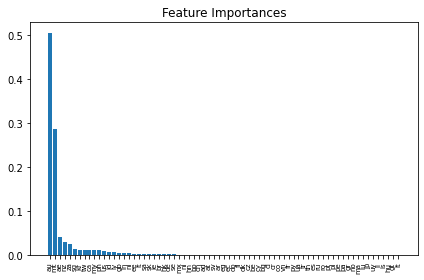

In [ ]:
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

The best predictors are:

1. Malta
2. Australia
3. The UAE
4. Singapore
5. The USA
6. Canada
7. South Africa
8. Malaysia
9. New Zealand
10. Taiwan

#**V. Conclusions**

Throughout our analysis, our main dataset for comparison was the YouGov poll results including what percentage of American millenials had heard of contemporary music artists. We also looked at global Spotify weekly charts, as well as critics' rankings of the top 1000 artists of all time. We saw that critics' rankings did not significantly correlate with fame among millenials. We ruled out critics' rankings as a predictor of fame among millenials. We found the same result for the relationship between Spotify streams in the U.S. and fame among millenials, so we dug deeper into the streams by country.

We decided to look to the Spotify global weekly data to figure out which country's chart was the best predictor of fame among millenials. While 4 of the top 10 countries are English-speaking, which falls in line with our hypothesis, the US was only weighted as 1.2793% of the model. The sum of all the English-speaking countries' weights made up less than 40% of the model. Malta was weighted at 49.3714%, making them the most heavily-weighted country by far, with only Australia coming anywhere close.

We can conclude that the best predictor of whether American millenials have heard of an artist is their popularity in Malta.

###**Limitations**

The YouGov poll couldn't have asked each millenial about every artist in existence. We only have data on the fame among millenials of 419 artists. There are likely artists whom some millenials have heard of who didn't make the list. Artists who weren't on the list were given a millenial fame score of 0 in our analysis, based on the assumption that their fame score would have otherwise been low. This missing data could introduce bias in our model.

After merging with the YouGov data, we also filled missing streams in the Spotify data with 0. This means that if an artist was number 201 in a country, their streams are counted as 0. This could also introduce bias, as only the top 200 in each country are represented.

Feature importances also do not give us any information about the strength of the actual model, just the weights of the features relative to each other. The RMSE of our model is 26.07536, which does seem high. Overall, this indicates that our model lacks predictive power. Within the model, however, we are still able to tease out which countries' streams had the most impact.